# Implementing VAR in PyMC3

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

# Generate VAR

In [5]:
from regime_switching.generate import chain, ar

In [6]:
T = 100
n_endog = 1
n_lag_endog = 2

# n_exog = 0

In [7]:
vg = ar.VARXGenerator.get_random_instance(endog=n_endog, lag_endog=n_lag_endog)
vg

VARXGenerator with params:
  <xarray.Dataset>
  Dimensions:              (endog: 1, exog: 0, lag_endog: 2, lag_exog: 0, pre_vals: 2, target: 1)
  Coordinates:
    * lag_exog             (lag_exog) int64 
    * lag_endog            (lag_endog) int64 1 2
    * endog                (endog) int64 0
    * target               (target) int64 0
    * exog                 (exog) int64 
    * pre_vals             (pre_vals) int64 -2 -1
  Data variables:
      coef_ar              (target, endog, lag_endog) float64 -0.1064 0.5708
      coef_exog            (target, exog, lag_exog) float64 
      coef_covariance      (target, endog) float64 0.1676
      coef_const           (target) float64 1.009
      coef_initial_values  (pre_vals, target) float64 0.8835 1.005

In [8]:
data = vg.generate(T + n_lag_endog)
data

<xarray.Dataset>
Dimensions:  (target: 1, time: 102)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * target   (target) int64 0
Data variables:
    output   (time, target) float64 1.649 0.939 1.982 1.661 ... 1.405 1.891 2.0

# Internals of `logp`

## Coefficient shapes

In [9]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [1] == (1,) 
ar: [1 1 2] == (1, 1, 2) 
cov: [1 1] == (1, 1) 
init: [2 1] == (2, 1)


## Pad the data

In [10]:
t_data = tt.as_tensor(data['output'].values)
t_data_pre = tt.concatenate([t_init, t_data], axis=0)
print(
    "data:", t_data.shape.eval(), "==", (T, n_endog),
    "\npadded:", t_data_pre.shape.eval(), "==", (n_lag_endog + T, n_endog)
)

data: [102   1] == (100, 1) 
padded: [104   1] == (102, 1)


## Get expected mean

In [11]:
# Sum up total AR effect
effect_ar = []
for i in range(n_lag_endog):
    # lag is i+1
    _start = n_lag_endog - (i + 1)
    _end = -(i + 1)
    q = tt.dot(t_data_pre[_start:_end, :], t_ar[:, :, i])
    effect_ar.append(q)
effect_ar = tt.add(*effect_ar)
effect_ar.shape.eval()  # == (T, n_endog)

array([102,   1])

In [12]:
expected_mean = effect_ar + t_const[None, :]
errors = t_data - expected_mean
errors.shape.eval()  # == (T, n_endog)

array([102,   1])

## Find likelihood

In [13]:
dist_innov = pm.MvNormal.dist(mu=0, **{"cov": t_cov})

like_innov = dist_innov.logp(errors)
like_innov.shape.eval()  # == (T, )

array([102])

In [14]:
dist_init = pm.Flat.dist()
# dist_init = pm.Normal.dist(mu=0, sigma=10, shape=[2])

like_init = dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
like_init.shape.eval()  # == (n_lag_endog, n_endog) ?

array([2, 1])

In [15]:
like_total = tt.sum(like_init) + tt.sum(like_innov)
like_total.shape.eval()  # == tuple()

array([], dtype=int64)

# Create class

In [16]:
# pm.distributions.continuous.get_tau_sigma

In [17]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [1] == (1,) 
ar: [1 1 2] == (1, 1, 2) 
cov: [1 1] == (1, 1) 
init: [2 1] == (2, 1)


In [18]:
from pymc3.distributions import draw_values

# from pymc3.distributions.distribution import generate_samples
# from pymc3.distributions.shape_utils import to_tuple


class VAR(pm.Continuous):
    
    def __init__(
        self, 
        n_endog, n_lag_endog, 
        t_const, t_init, t_ar,
        packed_chol,
        # chol_eta,
        # chol_sd_dist,
        # cov=None, tau=None, chol=None, lower=True,
        dist_init=pm.Flat.dist(), 
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.n_endog = int(n_endog)
        self.n_lag_endog = int(n_lag_endog)

        self.t_const = tt.as_tensor_variable(t_const)
        self.t_init = tt.as_tensor_variable(t_init)
        self.t_ar = tt.as_tensor_variable(t_ar)
        
        # Covariance distribution args for innovation process
        # TODO: Maybe allow non-MvNormal innovation dist?
        
        self.packed_chol = packed_chol
        self.chol = chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
        self.cov = tt.dot(chol, chol.T)
        
        # Distribution for initial values - default is Flat a.k.a. "no idea" 
        self.dist_init = dist_init
        
        # Test value
        self.mean = tt.as_tensor_variable(np.zeros(shape=(n_endog,)))
        
    @property
    def dist_innov(self) -> pm.Distribution:
        return pm.MvNormal.dist(mu=0, chol=self.chol)
        
    def logp(self, value: tt.Tensor) -> tt.TensorVariable:
        """f"""
        
        # Prepend initial values
        t_data = tt.as_tensor(value)
        try:
            t_data_pre = tt.concatenate([self.t_init, t_data], axis=0)
        except Exception:
            t_data_pre = self.t_init
        
        # Sum up total AR effect
        effect_ar = []
        for i in range(n_lag_endog):
            # lag is i+1
            _start = n_lag_endog - (i + 1)
            _end = -(i + 1)
            q = tt.dot(t_data_pre[_start:_end, :], self.t_ar[:, :, i])
            effect_ar.append(q)
        effect_ar = tt.add(*effect_ar)
        # effect_ar.shape.eval()  # == (T, n_endog)
        
        # Add constant to get errors
        expected_mean = effect_ar + self.t_const[None, :]
        errors = t_data - expected_mean
        # errors.shape.eval()  # == (T, n_endog)
        
        # Get likelihoods
        like_innov = self.dist_innov.logp(errors)
        # like_innov.shape.eval()  # == (T, )
        
        like_init = self.dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
        # like_init.shape.eval()  # == (n_lag_endog, n_endog) ?
        
        like_total = tt.sum(like_init) + tt.sum(like_innov)
        # like_total.shape.eval()  # == tuple()
        
        return like_total
    
    def random(self, point=None, size=None):
        a_const, a_init, a_ar, a_packed_chol, a_chol, a_cov = draw_values(
            [self.t_const, self.t_init, self.t_ar, self.packed_chol, self.chol, self.cov],
            point=point, size=size
        )
        T = int(self.shape[0])

        def gen_1():
            # TODO: Use initial values too! Needs to be implemented in VARXGenerator
            my_varx_gen = ar.VARXGenerator(
                endog=self.n_endog, lag_endog=self.n_lag_endog, 
                coef_ar=a_ar, coef_covariance=a_cov, coef_const=a_const,
                coef_initial_values=a_init,  # This seems correct - order is 'oldest' to 'newest'
                # Ignore nonstationary since these are samples
                check_kwargs=dict(action_nonstationary='ignore'),  
            )
            srs = my_varx_gen.generate(T)['output'].values
            return srs

        # TODO: what to do with `size`?
        random_samples = gen_1()
        return random_samples

In [19]:
# VAR.dist(n_endog=n_endog, n_lag_endog=n_lag_endog).logp(data['output'].values)

## Test in model

### Build model

In [20]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

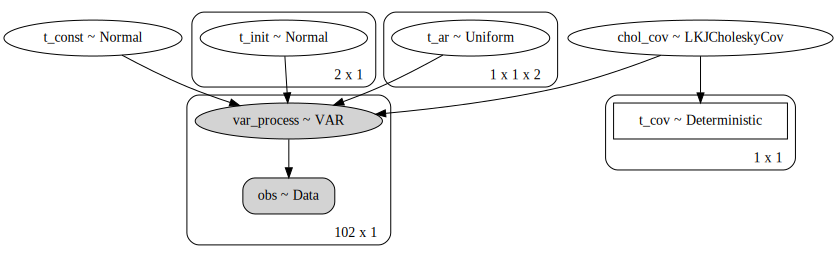

In [21]:
with pm.Model() as m:
    cov_sd_dist = pm.HalfCauchy.dist(beta=2.5)
    cov_eta = 2
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=cov_eta, n=n_endog, sd_dist=cov_sd_dist)
    # chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
    # cov = pm.Deterministic('t_cov', tt.dot(chol, chol.T))
    
    pm.Normal('t_const', 0, 10, shape=(n_endog,))
    pm.Normal('t_init', 0, 10, shape=(n_lag_endog, n_endog))

    # Note: maybe try Beta? Truncated Cauchy/Normal?
    pm.Uniform('t_ar', -1, 1, shape=(n_endog, n_endog, n_lag_endog))
    
    obs = pm.Data('obs', data['output'].values)
    var = VAR(
        'var_process', 
        n_endog=n_endog, n_lag_endog=n_lag_endog, 
        t_const=m['t_const'], 
        t_init=m['t_init'],
        t_ar=m['t_ar'],
        packed_chol=packed_chol, 
        observed=m['obs'],
    )
    cov = pm.Deterministic('t_cov', var.distribution.cov)

pm.model_to_graphviz(m)

### Fit

In [22]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [t_ar, t_init, t_const, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [03:09<00:00, 31.72draws/s]


### Get posterior predictive

In [23]:
with m:
    ppc = pm.sample_posterior_predictive(trace, samples=100)

/opt/conda/envs/rs-model/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


### Check traces

In [27]:
ifd = az.from_pymc3(
    trace=trace, 
    posterior_predictive=ppc,
    # dims={'var_process': ['time', 'draw']},
    coords={
        'time': np.arange(T), 
        'target': np.arange(n_endog), 
        'endog': np.arange(n_endog),
    }
)

arviz.data.io_pymc3 - WARNING - posterior predictive variable var_process's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


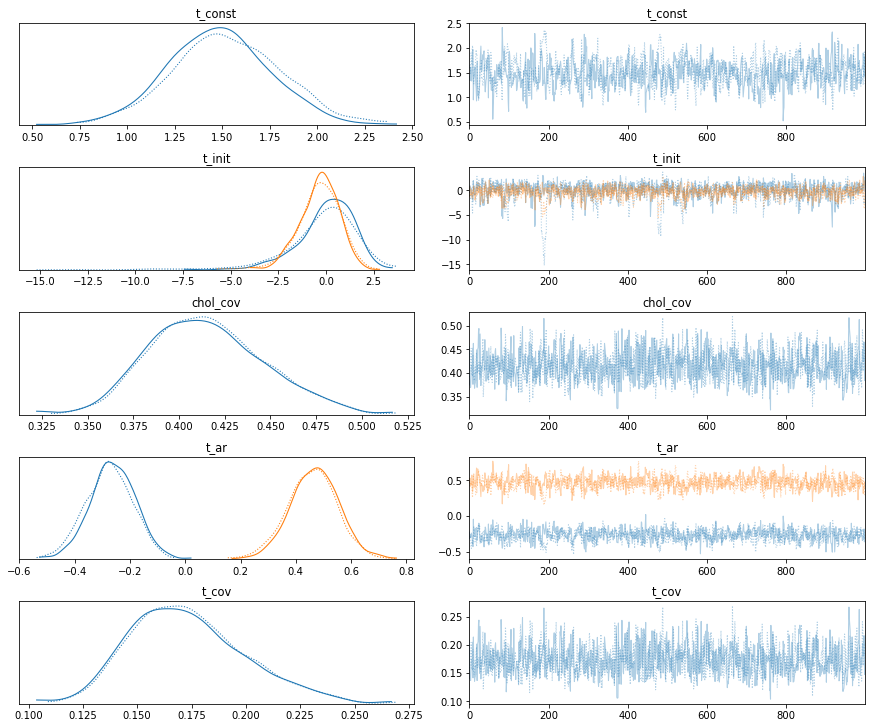

In [28]:
pm.traceplot(trace);

### Check posterior predictive

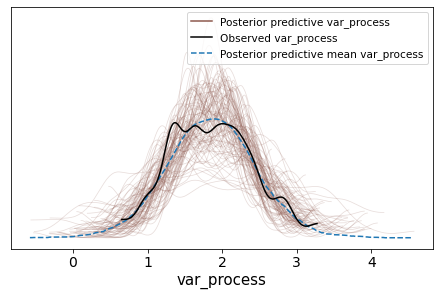

In [29]:
az.plot_ppc(ifd);

### Compare with actual values

In [30]:
# Estimated covariance matrix
ifd.posterior['t_cov'].mean(dim=['chain', 'draw']).values

array([[0.17351044]])

In [31]:
# Actual covariance matrix
vg.coef_covariance.values

array([[0.16764537]])

In [32]:
# Estimated constant term
ifd.posterior['t_const'].mean(dim=['chain', 'draw']).values

array([1.50490384])

In [33]:
vg.coef_const.values

array([1.00941444])

In [34]:
# Estimated constant term
ifd.posterior['t_ar'].mean(dim=['chain', 'draw']).values

array([[[-0.26850577,  0.46398511]]])

In [35]:
az.hdi(ifd.posterior['t_ar'].values, hdi_prob=0.95)

array([[[[-0.42466116, -0.1005026 ],
         [ 0.29088703,  0.63057106]]]])

In [36]:
vg.coef_ar.values

array([[[-0.10635429,  0.57079089]]])

In [37]:
# Estimated initial values
ifd.posterior['t_init'].mean(dim=['chain', 'draw']).values

array([[-0.14879782],
       [-0.36794342]])

In [39]:
az.hdi(ifd.posterior['t_init'].values, hdi_prob=0.95)

array([[[-3.42797281,  2.55658619]],

       [[-2.34669045,  1.73992829]]])

In [38]:
vg.coef_initial_values.values

array([[0.88353079],
       [1.00481652]])

### Plot range from PPC

In [40]:
vppc = ifd.posterior_predictive.rename({'var_process_dim_0': 'time', 'var_process_dim_1': 'target'})
v_mean = vppc['var_process'].mean(dim=['chain', 'draw'])
_v_hdi = az.hdi(vppc, hdi_prob=0.95)
_v_hdi['hdi'] = ['lower', 'upper']
v_hdi = _v_hdi['var_process'].to_dataset(dim='hdi')
v_vals = v_hdi.combine_first(v_mean.to_dataset(name='mean'))

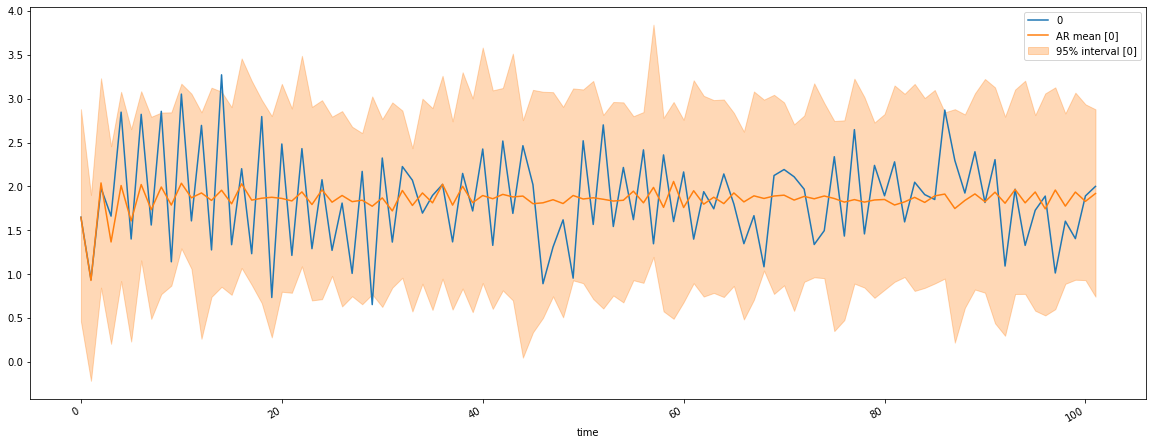

In [41]:
import matplotlib.pyplot as plt

axs = data['output'].to_series().unstack('target').plot(color='C0', figsize=(20, 8), subplots=True)
fig = axs[0].figure
for i, ax in enumerate(axs):
    hh = v_vals.isel(target=i)
    
    ax.plot(
        hh['time'], 
        hh['mean'].values, 
        color='C1', 
        label=f'AR mean [{i}]',
    )
    ax.fill_between(
        hh['time'], 
        hh['lower'].values, 
        hh['upper'].values, 
        color='C1', alpha=0.3, 
        label=f"95% interval [{i}]",
    )
    # v_mean.to_series().unstack('target').plot(color='C1', ax=axs, subplots=True)
    ax.legend()
fig;